In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

In [8]:
BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

In [9]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
print("BES_Panel",  BES_Panel.shape )
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

BES_Panel (31409, 733)
var_type (733, 1)


In [10]:
import load_url

In [11]:
# # helper to load url
# # runs webserver and loads url with webbrowswer module
# import sys

# def load_url(path):
#     PORT = 8000
#     httpd = StoppableHTTPServer(("127.0.0.1",PORT), handler)
#     thread.start_new_thread(httpd.serve, ())
#     webbrowser.open_new('http://localhost:%s/%s'%(PORT,path))
#     input("Press <RETURN> to stop server\n")
#     httpd.stop()
#     print("To restart server run: \n%s"%server)


# if sys.version_info[0] == 2:
#     import SimpleHTTPServer, BaseHTTPServer
#     import socket
#     import thread
#     import webbrowser
#     handler = SimpleHTTPServer.SimpleHTTPRequestHandler
#     input = raw_input
#     server = "python -m SimpleHTTPServer 8000"

#     class StoppableHTTPServer(BaseHTTPServer.HTTPServer):

#         def server_bind(self):
#             BaseHTTPServer.HTTPServer.server_bind(self)
#             self.socket.settimeout(1)
#             self.run = True

#         def get_request(self):
#             while self.run:
#                 try:
#                     sock, addr = self.socket.accept()
#                     sock.settimeout(None)
#                     return (sock, addr)
#                 except socket.timeout:
#                     pass

#         def stop(self):
#             self.run = False

#         def serve(self):
#             while self.run:
#                 self.handle_request()


# else:
#     import http.server, http.server
#     import socket
#     import _thread as thread
#     import webbrowser
#     handler = http.server.SimpleHTTPRequestHandler
#     server = "python -m http.server 8000"

#     class StoppableHTTPServer(http.server.HTTPServer):

#         def server_bind(self):
#             http.server.HTTPServer.server_bind(self)
#             self.socket.settimeout(1)
#             self.run = True

#         def get_request(self):
#             while self.run:
#                 try:
#                     sock, addr = self.socket.accept()
#                     sock.settimeout(None)
#                     return (sock, addr)
#                 except socket.timeout:
#                     pass

#         def stop(self):
#             self.run = False

#         def serve(self):
#             while self.run:
#                 self.handle_request()

In [12]:
import sys
sys.version_info[0]

3

In [13]:
BES_min = pd.read_hdf(BES_data_folder+"BESW8min.hdf")

BES_min.var().sort_values()
W9_vars = [x for x in BES_min.columns if "W9" in x]
BES_min.drop(W9_vars, axis=1, inplace=True)
BES_min.fillna(-1).to_stata(BES_data_folder+"BES2015_W8_v1.3_nan_minus1_allcat_allBrit.dta")

In [14]:
cat_vars = BES_Panel.columns[(var_type["type"]==3)]
# set( str_df["to"].values ).intersection( set(cat_vars))
# cat_vars

In [15]:
cat_vars_30 = list( set(BES_min.columns).intersection(set(cat_vars))  )
BES_min[cat_vars_30].fillna(-1).to_stata(BES_data_folder+"BES2015_W8_30_cats.dta")

In [16]:
BES_min = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3_nan_minus1_allcat_allBrit.dta")
BES_min["euRefVote"].value_counts()

 1.0    14803
 0.0    14261
-1.0     2343
Name: euRefVote, dtype: int64

In [17]:
# trying to estimate the O(n) for the bnlearn programme by the number of variables
# a = np.sqrt( [1,10,25,60,130,210,345] )
# b = [10,20,30,40,50,60,70]
# z = a[3] + ((a[6]-a[3])/(b[6]-b[3])) * (290-b[3])
# z*z/3600

In [18]:
# LOAD NETWORK LINK STRENGTHS OUTPUT BY BNLEARN

# strengths = pd.read_csv("../../Bayesian Networks/bayes_net_data/strengths_allcats_allBrit.csv")
# strengths = pd.read_csv("LiberalDemocats_strengths.csv")
# strengths = pd.read_csv("LiberalDemocats_small_strengths.csv")
strengths = pd.read_csv("strengths_BES_Eng_EU_euRef0.csv")
# strengths = pd.read_csv("strengths_BES_Eng_EU_euRef1.csv")
# strengths = pd.read_csv("strengths_BES_Eng_EU_euRef-1.csv")
# strengths = pd.read_csv("strengths_BES_Eng_EU0.csv")
# strengths = pd.read_csv("../../Bayesian Networks/bayes_net_data/strengths_allcats.csv")

In [19]:
str_df = strengths.drop('Unnamed: 0',axis=1).sort_values(by="strength")

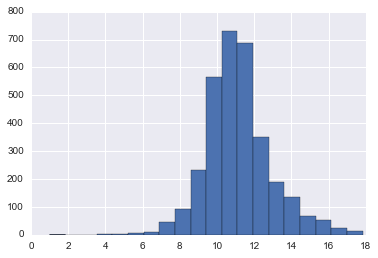

In [20]:
log_positive_str = np.log(np.abs(str_df["strength"]))
log_positive_str = log_positive_str - min(log_positive_str) +1
log_positive_str.hist(bins=20)

In [21]:
# to create and plot a network diagram in python
import plotly.plotly as py
from plotly.graph_objs import *
import networkx as nx

In [22]:
G = nx.DiGraph( )
for i in str_df.index:
    if log_positive_str.loc[i] > 12: # filter weak links
        G.add_node( str_df.loc[i]["from"] )
        G.add_node( str_df.loc[i]["to"]   )
        G.add_edge( str_df.loc[i]["from"] , str_df.loc[i]["to"] , weight=log_positive_str.loc[i] )

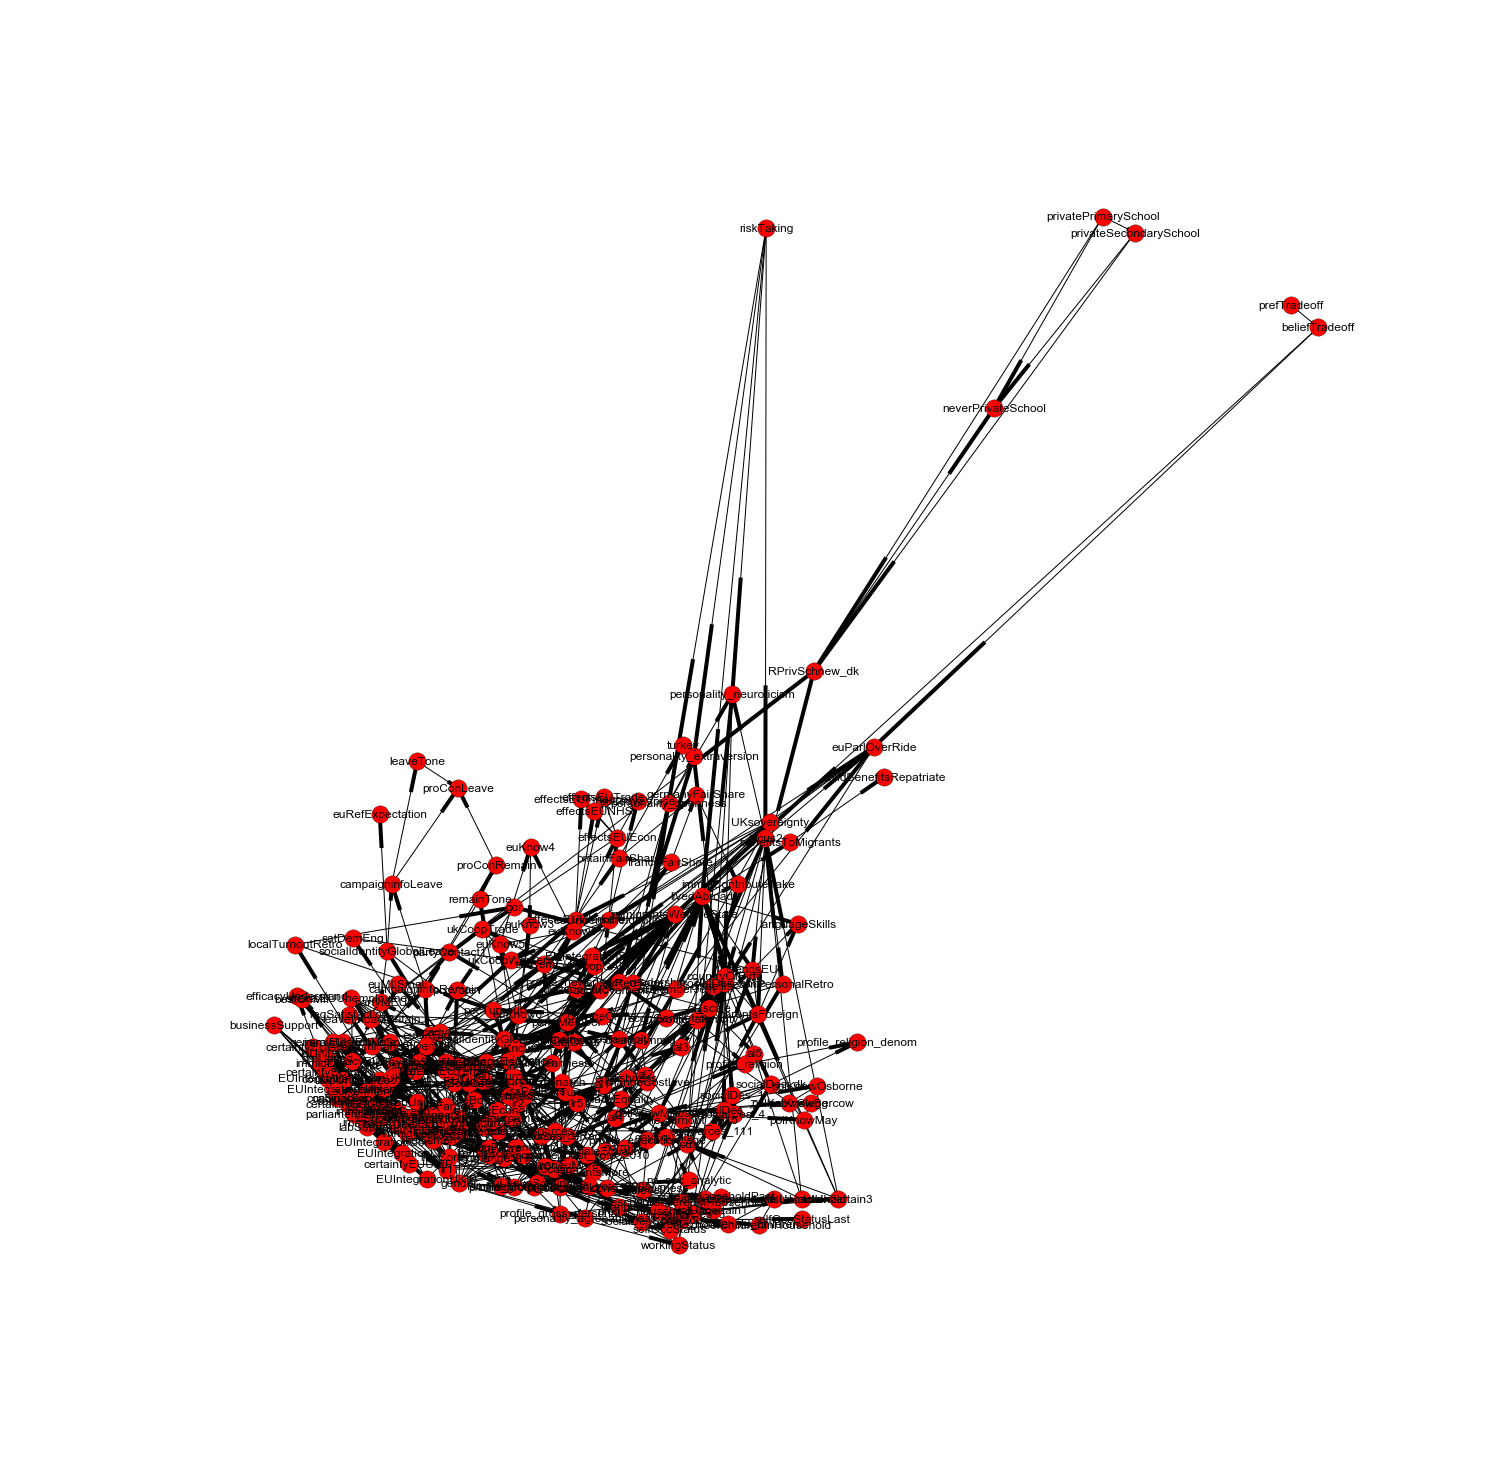

In [23]:
plt.figure(figsize=(20,20));
pos=nx.spring_layout(G,weight='weight')
nx.draw(G,pos, with_labels=True)

In [24]:
import json
from networkx.readwrite import json_graph

for n in G:
    G.node[n]['name'] = n

d = json_graph.node_link_data(G)
json.dump(d, open('force/force.json','w'))
json.dump(d, open('force/force_libdems.json','w'))

In [27]:
from load_url import load_url

In [28]:
# open 
load_url('force/force.html')

127.0.0.1 - - [29/Apr/2017 14:30:27] "GET /force/force.json HTTP/1.1" 200 -


Press <RETURN> to stop server

To restart server run: 
python -m http.server 8000
